In [1]:
# Importation des modules & fonctions 
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import cv2
from importlib import reload
# Fonctions persos 
from functions.imshowByCv2 import * # Affichage d'image
from functions.createRandomPixel2DArray import* # On tire au hasard des pixels dans l'image de façon unique en respectant un rayon 
from functions import repartImg

<center> <h3> Importation et paramétrage de l'image de travail </h3> </center>

In [2]:
# Plutot TEST
#BR = (2020,5850) TL = (465,4650) Image normalisé (0, 1) float32
imgAvant = np.load('./data/img20180828.npy')
imgApres = np.load('./data/img20180927.npy')
#   Récupération information image
imgShape = imgAvant.shape
nBande = imgShape[-1]

In [29]:
# PLUTOT TRAIN
# TL = (465,4650) BR = (1365, 5850) Image normalisé (0,1) float32
imgApres = np.load('./data/img20180729.npy')
imgAvant = np.load('./data/img20180719.npy')
#   Récupération information image
imgShape = imgAvant.shape
nBande = imgShape[-1]

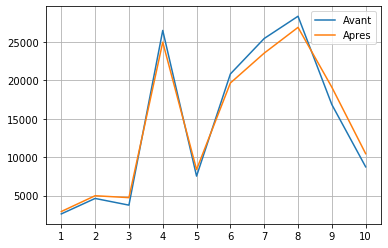

In [9]:
# Répartition des couleurs
repartTabImg = repartImg(np.array([imgAvant, imgApres]), ["Avant", "Apres"])

In [6]:
# Affichage
nomTab = ["Image avant", "Image après "]
imgTab = [imgAvant, imgApres]
imshowByCv2(nomTab,imgTab)
del nomTab,imgTab

<center> <h3> Estimation par réseaux de neurones </h3> </center>

<center> <h4> Set d'entrainement </h4> </center>

In [29]:
#   Paramètre d'entrainement par carrée
# Le réseaux prend en entrée un carrée de r pixel pour estimer un pixel
rayon = 7 # Carrée de 2*r + 1 de côté
nRandomPixel, nTrain = createRandomPixel2DArray(rayon, imgShape)

1827626


In [3]:
#   Paramètre d'entrainement par pixel
nRandomPixel, nTrain = createRandomPixel2DArray(0, imgShape)

1866000


In [4]:
# Set d'entrainement par pixel
trainX = np.zeros([nTrain, nBande])
trainY = np.zeros([nTrain, nBande])
for i in range(nTrain):
    trainX[i] = imgAvant[nRandomPixel[0,i],nRandomPixel[1,i]]
    trainY[i] = imgApres[nRandomPixel[0,i],nRandomPixel[1,i]]

In [9]:
# Set d'entrainement, en entrée un carrée de rayon 'rayon' et une sortie estimant un pixel
trainX = np.zeros([nTrain, # Nombre échantillons 
              2*rayon+1, # Taille du carrée (Vertical)
              2*rayon+1, # Taille du carrée (Horizontal)
              nBande]) # Bande spectrale
trainY = np.zeros(trainX.shape)
for i in range(nTrain):
    centrePixel = [nRandomPixel[0,i],nRandomPixel[1,i]]
    trainX[i,:,:,:] = imgAvant[centrePixel[0]-rayon:centrePixel[0]+rayon+1,
                             centrePixel[1]-rayon:centrePixel[1]+rayon+1,
                             :]
    trainY[i,:,:,:] = imgApres[centrePixel[0]-rayon:centrePixel[0]+rayon+1,
                             centrePixel[1]-rayon:centrePixel[1]+rayon+1,
                             :]

NameError: name 'rayon' is not defined

<center> <h4> Conception du réseau </h4> </center>

In [5]:
#   Encodeur par zone
inputSizeEnco = (2*rayon + 1)**2 * nBande
encoLayerNode = [int(inputSizeEnco*.9), int(inputSizeEnco*.75), int(inputSizeEnco*.5),int(inputSizeEnco*.25),int(inputSizeEnco*.1)]
encoSize = len(encoLayerNode) # Taille de l'encodeur
encoLayer = [None] * encoSize

inputImgLayer = keras.layers.Input(shape=(inputSizeEnco,), name = 'input')

encoLayer[0] = keras.layers.Dense(encoLayerNode[0], activation='linear', name='enco0')(inputImgLayer)
for i in range(1,encoSize):
    encoLayer[i] = keras.layers.Dense(encoLayerNode[i], activation='tanh', name=('enco'+str(i)))(encoLayer[i-1])
encodeur = keras.models.Model(inputImgLayer, encoLayer[-1])

NameError: name 'rayon' is not defined

In [5]:
# Encodeur par pixel
inputSizeEnco = nBande
encoLayerNode = [9,9,8,8,7]
encoSize = len(encoLayerNode)
encoLayer = [None] * encoSize

inputImgLayer = keras.layers.Input(shape=(inputSizeEnco,), name = 'input')

encoLayer[0] = keras.layers.Dense(encoLayerNode[0], activation='linear', name='enco0')(inputImgLayer)
for i in range(1,encoSize):
    encoLayer[i] = keras.layers.Dense(encoLayerNode[i], activation='tanh', name=('enco'+str(i)))(encoLayer[i-1])
encodeur = keras.models.Model(inputImgLayer, encoLayer[-1])

In [6]:
#   Décodeur
decoLayerNode = [inputSizeEnco] * encoSize
for i in range(encoSize-1):
    decoLayerNode[i] = encoLayerNode[-2 -i]
decoSize = len(decoLayerNode)
decoLayer = [None] * decoSize

decoLayer[0] = keras.layers.Dense(decoLayerNode[0], activation='tanh', name='deco0')(encoLayer[-1])
for i in range(1, decoSize):
    decoLayer[i] = keras.layers.Dense(decoLayerNode[i], activation='tanh', name=('deco'+str(i)))(decoLayer[i-1])
autoencodeur = keras.models.Model(inputImgLayer, decoLayer[-1])

In [7]:
#   Compilation des réseaux
encodeur.compile(loss = 'mean_squared_error',
                optimizer = keras.optimizers.RMSprop())
autoencodeur.compile(loss = 'mean_squared_error',
                optimizer = keras.optimizers.RMSprop())

In [8]:
#   Affichage de l'architecture
autoencodeur.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
enco0 (Dense)                (None, 9)                 99        
_________________________________________________________________
enco1 (Dense)                (None, 9)                 90        
_________________________________________________________________
enco2 (Dense)                (None, 8)                 80        
_________________________________________________________________
enco3 (Dense)                (None, 8)                 72        
_________________________________________________________________
enco4 (Dense)                (None, 7)                 63        
_________________________________________________________________
deco0 (Dense)                (None, 8)                 64  

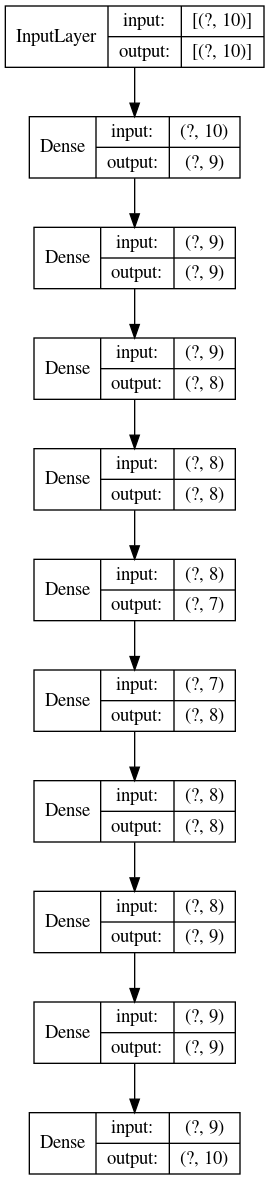

In [104]:
#   Sauvegarde de l'architecture
keras.utils.plot_model(autoencodeur, show_layer_names=False, show_shapes=True, to_file='./output/model_autoencodeur.png')

<center> <h4> Entrainement </h4> </center>

In [9]:
# Préparation des données, on applatie
trainXflat = np.reshape(trainX, [nTrain, -1])
trainYflat = np.reshape(trainY, [nTrain, -1])

In [10]:
#   Entrainement
nEpoch = 50
batchSize = 25000
history = autoencodeur.fit(trainXflat, trainYflat,
                            epochs=nEpoch,
                            batch_size=batchSize,
                            shuffle = True,
                            verbose = 1)

Train on 466500 samples
Epoch 1/50
466500/466500 [==============================] - 3s 6us/sample - loss: 0.0092
Epoch 2/50
466500/466500 [==============================] - 1s 2us/sample - loss: 0.0020
Epoch 3/50
466500/466500 [==============================] - 1s 2us/sample - loss: 0.0014
Epoch 4/50
466500/466500 [==============================] - 1s 2us/sample - loss: 0.0011
Epoch 5/50
466500/466500 [==============================] - 1s 1us/sample - loss: 0.0010
Epoch 6/50
466500/466500 [==============================] - 1s 2us/sample - loss: 9.6519e-04
Epoch 7/50
466500/466500 [==============================] - 1s 2us/sample - loss: 9.5495e-04
Epoch 8/50
466500/466500 [==============================] - 1s 2us/sample - loss: 9.1971e-04
Epoch 9/50
466500/466500 [==============================] - 1s 2us/sample - loss: 9.3047e-04
Epoch 10/50
466500/466500 [==============================] - 1s 2us/sample - loss: 9.0053e-04
Epoch 11/50
466500/466500 [==============================] - 1s 2

<center> <h4> Test </h4> </center>

In [ ]:
# CODE A REFAIRE COMPLETEMENT TELLEMENT IL EST NUL
predShape = [imgShape[0] - 2 * rayon,
             imgShape[1] - 2 * rayon,
             nBande]
predImg = np.zeros(predShape)
for i in range(rayon, imgShape[0] - 2*rayon, 2*rayon + 1):
    for j in range(rayon, imgShape[1] - 2*rayon, 2*rayon + 1):
        imgAvantFlat = np.reshape(imgAvant[i-rayon:i+rayon+1,j-rayon:j+rayon+1,:], [1,-1])
        carrePred = autoencodeur.predict(imgAvantFlat)
        predImg[i-rayon:i+rayon+1,j-rayon:j+rayon+1,:] = np.reshape(carrePred, [2*rayon +1, 2*rayon + 1, nBande])

In [15]:
# Estimation avec les images espacés
imgAvant = np.load('./data/img20180828.npy')
imgApres = np.load('./data/img20180927.npy')
imgShape = imgAvant.shape
nBande = imgShape[-1]
flatImg = np.reshape(imgAvant, [imgShape[0] * imgShape[1], nBande])
predImg = autoencodeur.predict(flatImg)
predImg = np.reshape(predImg, imgShape)

In [11]:
# Estimation avec les images réduites
imgApres = np.load('./data/img20180729.npy')
imgAvant = np.load('./data/img20180719.npy')
imgShape = imgAvant.shape
nBande = imgShape[-1]
flatImg = np.reshape(imgAvant, [imgShape[0] * imgShape[1], nBande])
predImg = autoencodeur.predict(flatImg)
predImg = np.reshape(predImg, imgShape)

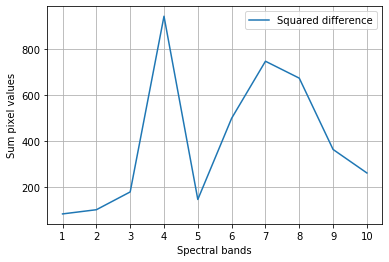

array([[ 82.045525, 100.300224, 177.80635 , 942.97076 , 145.01459 ,
        498.55145 , 747.01196 , 673.3154  , 362.7359  , 260.36966 ]],
      dtype=float32)

In [129]:
reload(repartImg)
repartImg.repartImg(np.array([subImg]), ["Squared difference"])

In [38]:
imshowByCv2(['Prédiction de test', 'Image après', 'Image avant'], [predImg, imgApres, imgAvant])

In [24]:
subImg = np.power(predImg - imgApres, 2)
nomTab = ['Avant', 'Apres']
imgTab = [imgAvant, imgApres]
for i in range(nBande):
    nomTab.append('Difference ' + str(i))
    imgTab.append(subImg[:,:,i])
imshowByCv2(nomTab,imgTab)

In [29]:
subImg = np.power(predImg - imgApres, 2)
normIm = lambda im: im / np.max(im)
cv2.imwrite('output3/imgAvant.jpg', 255* normIm(imgAvant[:,:,0:3]))
cv2.imwrite('output3/imgApres.jpg', 255 * normIm(imgApres[:,:,0:3]))
for i in range(nBande):
    cv2.imwrite('output3/subImg' + str(i) +'.jpg', 255 * normIm(subImg[:,:,i]))

In [24]:
subImg = np.power(predImg - imgApres,2)
subImg /= np.max(subImg[:,:,2])
threshold = .002
imgRGB = np.zeros( [imgShape[0], imgShape[1], 3])
for i in range(imgShape[0]):
    for j in range(imgShape[1]):
        if subImg[i,j,2] > threshold:
            imgRGB[i,j] = [0, 0, 1]
        else:
            imgRGB[i,j] = imgApres[i,j,0:3]
imshowByCv2(['oui','avant','apres','oops'], [imgRGB,imgAvant,imgApres, subImg[:,:,2]])

In [27]:
cv2.imwrite('makeupLarge.jpg', 255*imgRGB)

True